# Approach 1: Multi-Layer Perceptron; Neural Network

Curse: IS4242, Semster 1, 2024

Team: LLP


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display

## 1.1 Preparaing data
The train and test dataframe contains merged data of all data based on user_id and item_id as foreign key.


In [9]:
df_train = pd.read_csv('data/train.csv', index_col=None)
df_test = pd.read_csv('data/test.csv', index_col=None)
display(df_train.head())
display(df_test.head())
display(df_train.info())
display(df_test.info())

,user_id,item_id,rating,user_age,user_gender,user_occupation,user_zip,release_date,genre
0,1,1,5,24,M,technician,Arizona,1995.0,Animation
1,1,2,3,24,M,technician,Arizona,1995.0,Action
2,1,3,4,24,M,technician,Arizona,1995.0,Thriller
3,1,4,3,24,M,technician,Arizona,1995.0,Action
4,1,5,3,24,M,technician,Arizona,1995.0,Crime


,user_id,item_id,rating,user_age,user_gender,user_occupation,user_zip,release_date,genre
0,1,20,4,24,M,technician,Arizona,1995.0,Drama
1,1,33,4,24,M,technician,Arizona,1995.0,Action
2,1,61,4,24,M,technician,Arizona,1994.0,Drama
3,1,117,3,24,M,technician,Arizona,1996.0,Action
4,1,155,2,24,M,technician,Arizona,1987.0,Musical


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90570 entries, 0 to 90569
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          90570 non-null  int64  
 1   item_id          90570 non-null  int64  
 2   rating           90570 non-null  int64  
 3   user_age         90570 non-null  int64  
 4   user_gender      90570 non-null  object 
 5   user_occupation  90570 non-null  object 
 6   user_zip         90570 non-null  object 
 7   release_date     90562 non-null  float64
 8   genre            90570 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 6.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9430 entries, 0 to 9429
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          9430 non-null   int64  
 1   item_id          9430 non-null   int64  
 2   rating           9430 non-null   int64  
 3   user_age         9430 non-null   int64  
 4   user_gender      9430 non-null   object 
 5   user_occupation  9430 non-null   object 
 6   user_zip         9430 non-null   object 
 7   release_date     9429 non-null   float64
 8   genre            9430 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 663.2+ KB


None

Release date drop the Nan value

In [10]:
df_train = df_train.dropna(subset=['release_date'])
df_test = df_test.dropna(subset=['release_date'])

In [11]:
# Drop user_id and item_id for train and test data set
df_train = df_train.drop(['user_id', 'item_id'], axis=1)
df_test = df_test.drop(['user_id', 'item_id'], axis=1)


### 1.12 Generate count plut on each feature to check the distribution

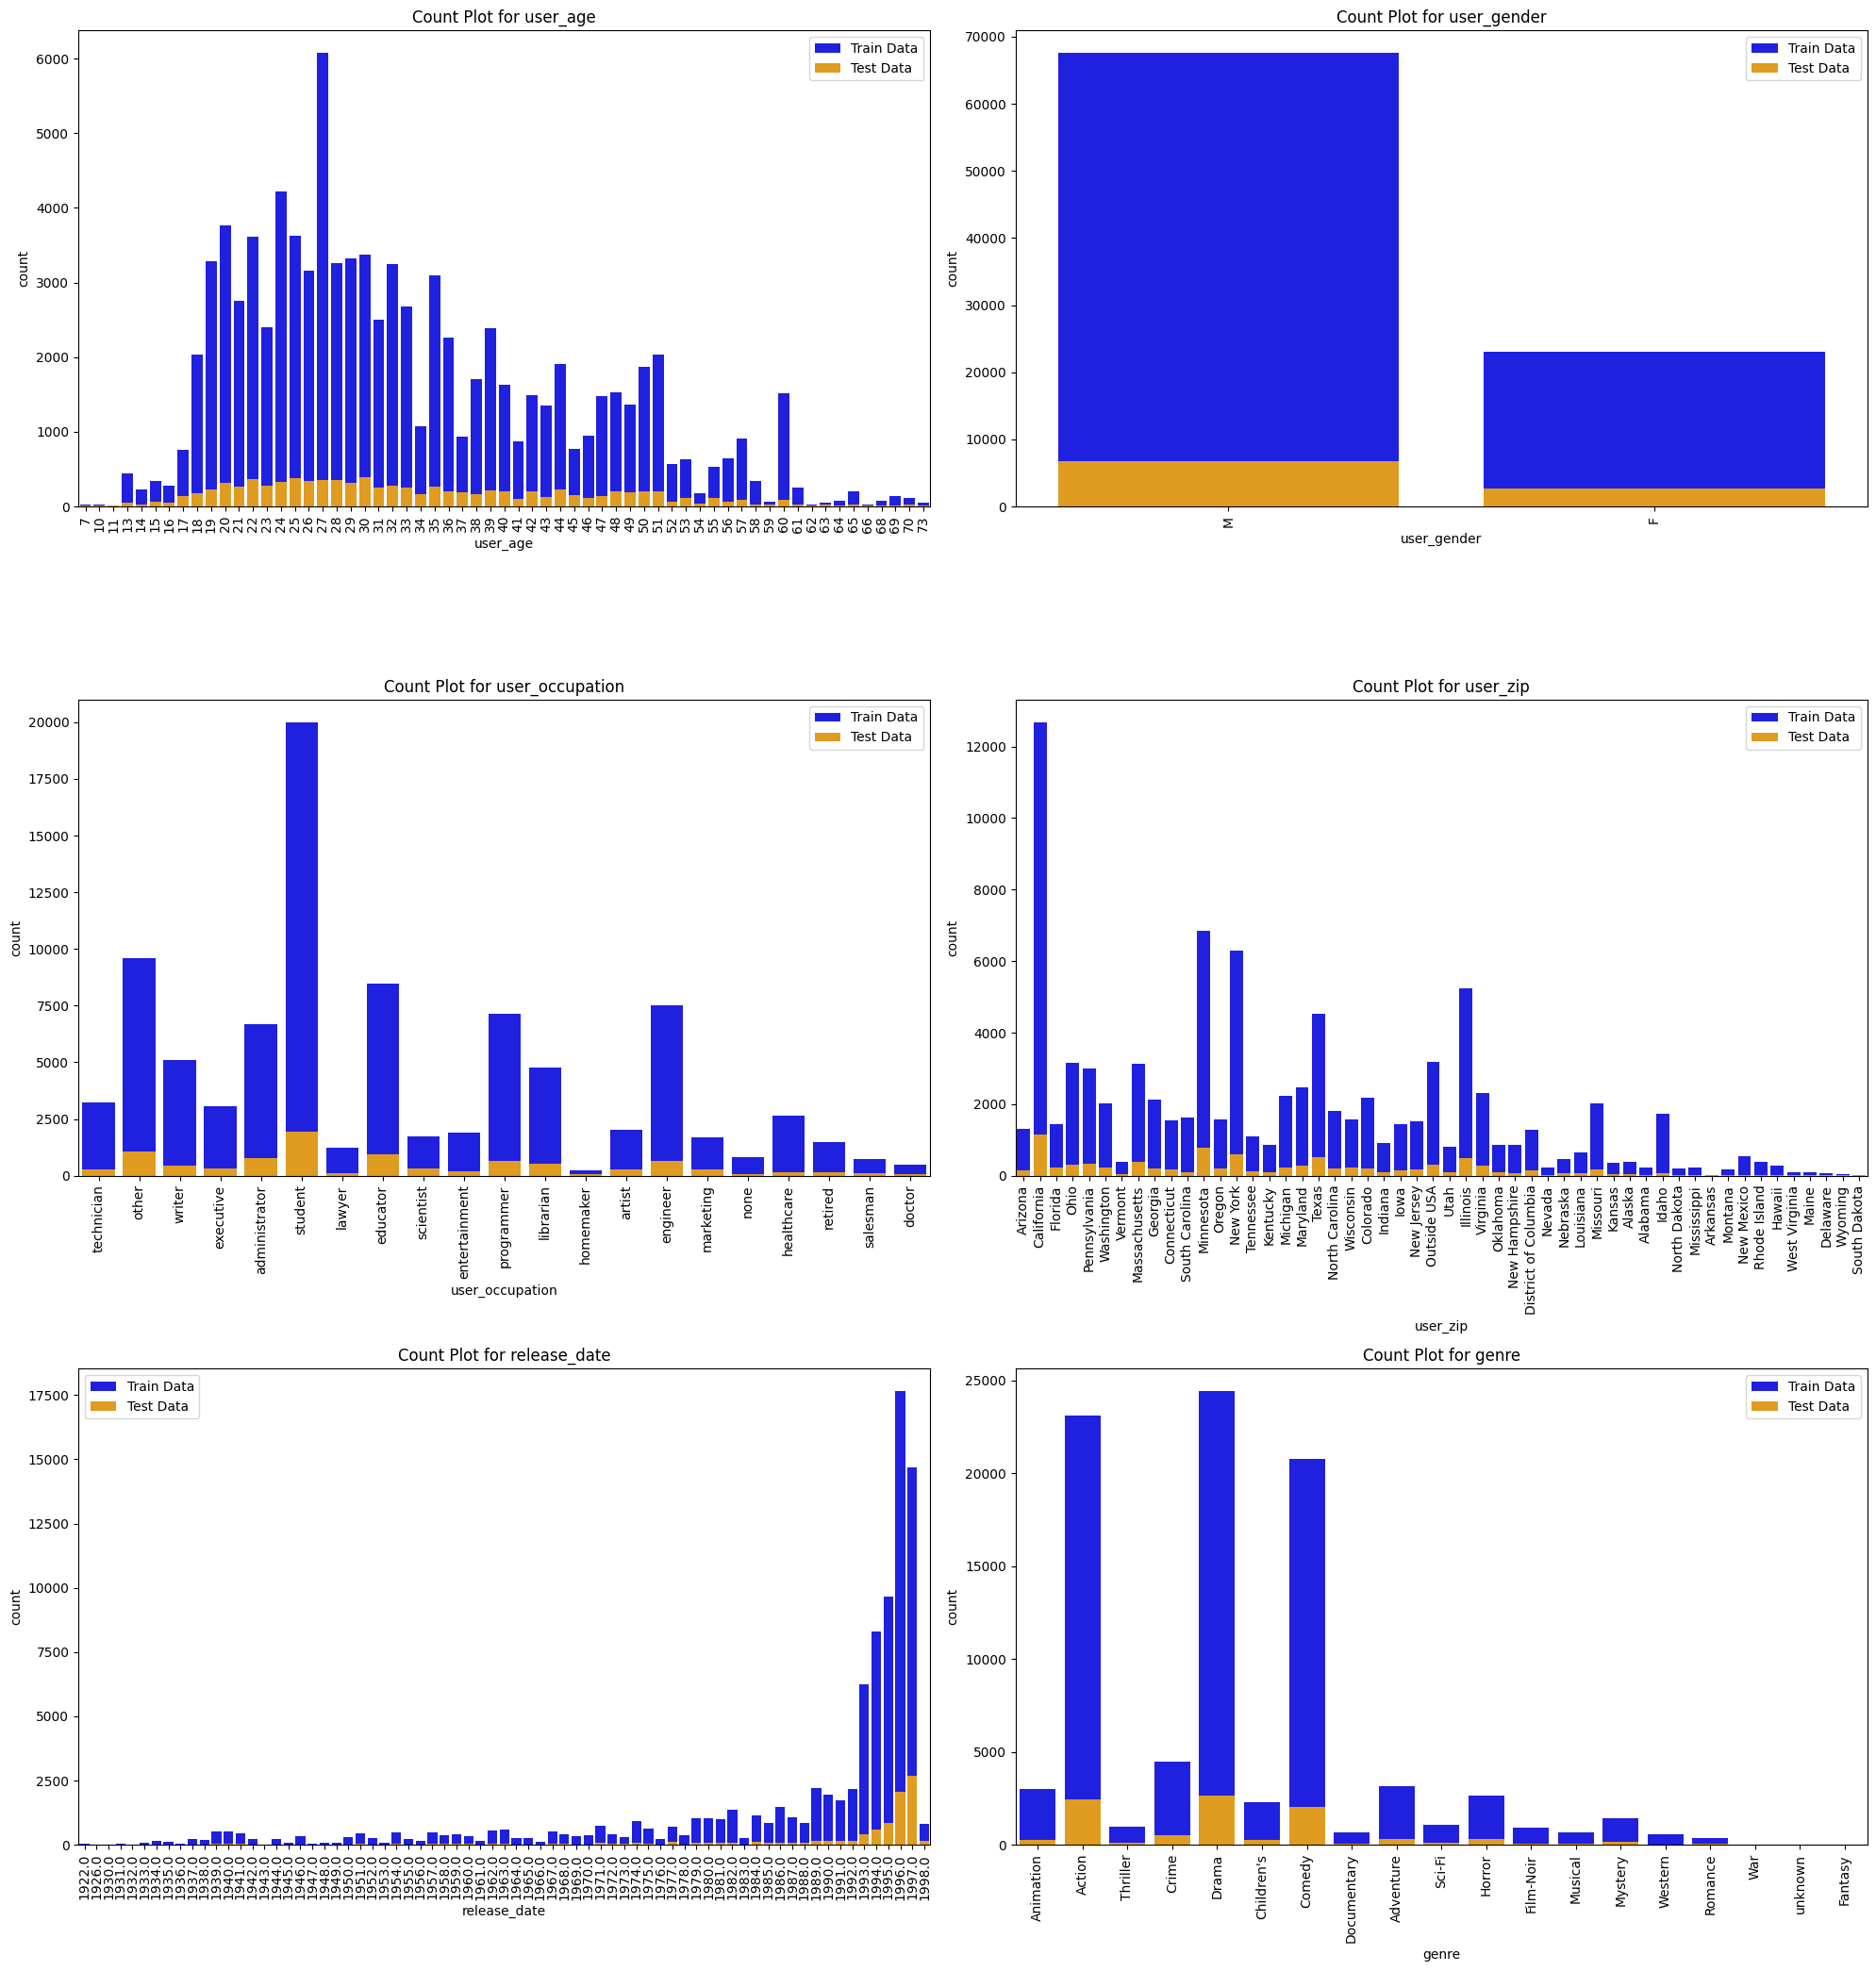

In [12]:
features = [col for col in df_test.columns if col != 'rating']

# Number of features
num_features = len(features)

# Calculate the number of rows and columns for subplots
nrows = (num_features + 1) // 2
ncols = 2

# Create a figure with subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 7 * nrows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot count plots for each feature
for i, feature in enumerate(features):
    sns.countplot(x=feature, data=df_train, ax=axes[i], color='blue', label='Train Data')
    sns.countplot(x=feature, data=df_test, ax=axes[i], color='orange', label='Test Data')
    axes[i].set_title(f'Count Plot for {feature}')
    plt.setp(axes[i].get_xticklabels(), rotation=90)
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()


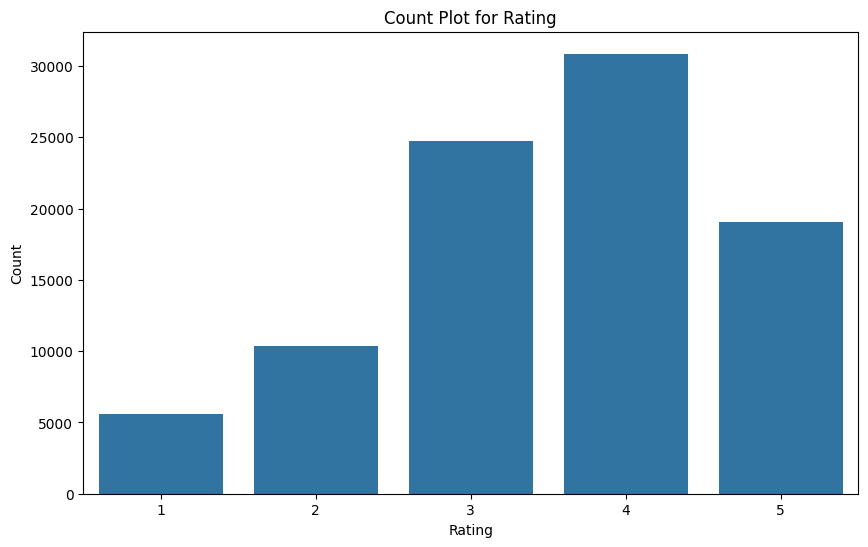

In [13]:
# Create a count plot for the 'rating' column
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df_train)
plt.title('Count Plot for Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### 1.13 Manually label like or dislike

In [14]:
# Add a new column 'like_dislike' to df_train and df_test based on the rating
df_train['like_dislike'] = df_train['rating'].apply(lambda x: True if x >= 4 else False)
df_test['like_dislike'] = df_test['rating'].apply(lambda x: True if x >= 4 else False)

# Display the first few rows to verify the new column
display(df_train.head())
display(df_test.head())

,rating,user_age,user_gender,user_occupation,user_zip,release_date,genre,like_dislike
0,5,24,M,technician,Arizona,1995.0,Animation,True
1,3,24,M,technician,Arizona,1995.0,Action,False
2,4,24,M,technician,Arizona,1995.0,Thriller,True
3,3,24,M,technician,Arizona,1995.0,Action,False
4,3,24,M,technician,Arizona,1995.0,Crime,False


,rating,user_age,user_gender,user_occupation,user_zip,release_date,genre,like_dislike
0,4,24,M,technician,Arizona,1995.0,Drama,True
1,4,24,M,technician,Arizona,1995.0,Action,True
2,4,24,M,technician,Arizona,1994.0,Drama,True
3,3,24,M,technician,Arizona,1996.0,Action,False
4,2,24,M,technician,Arizona,1987.0,Musical,False


## 1.2 Start build Neuron network for classification

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import pandas as pd
import numpy as np


### 1.21 define train and test class for feature engineering and converting into tensor

In [36]:
class train_dataset(torch.utils.data.Dataset):
    def __init__(self, data:pd.DataFrame):
        self.data = data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]
    def process_with_embeddings(self):
        # One-hot encoding for gender
        gender_ohe = pd.get_dummies(self.data['user_gender'], drop_first=True)  # Drop first to avoid collinearity
        self.data = self.data.drop(['user_gender'],axis=1)
        self.data = pd.concat([self.data, gender_ohe], axis=1) 

        # Encoding categorical features
        categorical_cols = ['user_occupation', 'user_zip']
        oe = OrdinalEncoder()
        self.data[categorical_cols] = oe.fit_transform(self.data[categorical_cols])

        genre_len = 1
        occupation_len = len(oe.categories_[0])
        zip_len = len(oe.categories_[1])

        # Handling numerical features
        scaler = StandardScaler()
        self.data[['user_age', 'release_date']] = scaler.fit_transform(self.data[['user_age', 'release_date']])

        # Separate categorical, numerical, and one-hot encoded gender
        self.X_categorical = self.data[categorical_cols].values  # Ordinal encoded categorical data
        self.X_numerical = self.data[['user_age', 'release_date']].values   # Scaled numerical data
        self.X_gender = self.data[['M']].values  # One-hot encoded gender (only one column 'Male' due to drop_first=True)

        # Convert labels
        self.y = self.data['like_dislike'].values       
        
        return genre_len, occupation_len, zip_len
    
    def mix_input_to_tensor(self):
        # Convert data to PyTorch tensors
        X_categorical_tensor = torch.tensor(self.X_categorical, dtype=torch.long)
        X_numerical_tensor = torch.tensor(self.X_numerical, dtype=torch.float32)
        X_gender_tensor = torch.tensor(self.X_gender, dtype=torch.float32) 
        y_tensor = torch.tensor(self.y, dtype=torch.float32).unsqueeze(1) 
        return X_categorical_tensor, X_numerical_tensor, X_gender_tensor, y_tensor
    
    def process_with_one_hot_encoding(self):
        categorical_cols = ['genre', 'user_occupation', 'user_zip', 'user_gender']
        self.data = pd.get_dummies(self.data, columns=categorical_cols, drop_first=True)

         # Handling numerical features
        numerical_cols = ['user_age', 'release_date']
        scaler = StandardScaler()
        self.data[numerical_cols] = scaler.fit_transform(self.data[numerical_cols])

        return self.data
        
        

    def ohe_to_tensor(self):  
        # Convert boolean columns to integers
        self.data = self.data.astype({col: 'int' for col in self.data.select_dtypes(include=['bool']).columns})
           
        # Convert data to PyTorch tensors
        X_tensor = torch.tensor(self.data.drop(['rating', 'like_dislike'], axis=1).values, dtype=torch.float32)
        y_tensor = torch.tensor(self.data['like_dislike'].values, dtype=torch.float32).unsqueeze(1)
        return X_tensor, y_tensor
        



class test_dataset(train_dataset):
    def __init__(self, data: pd.DataFrame):
        super().__init__(data)
    def test_tensor_conversion(self):
        # Convert boolean columns to integers
        self.data = self.data.astype({col: 'int' for col in self.data.select_dtypes(include=['bool']).columns})

        # Add 'genre_Fantasy' and 'genre_unknown' columns to self.data and set them to 0
        self.data['genre_Fantasy'] = 0
        self.data['genre_unknown'] = 0
           
        # Convert data to PyTorch tensors
        X_tensor = torch.tensor(self.data.drop(['rating', 'like_dislike'], axis=1).values, dtype=torch.float32)
        y_tensor = torch.tensor(self.data['like_dislike'].values, dtype=torch.float32).unsqueeze(1)
        return X_tensor, y_tensor

### 1.22 Define MLP

In [17]:
class MLP(nn.Module):
    def __init__(self, input_dim, n_class):
        super(MLP, self).__init__()        
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer for binary classification
        

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        return x

### 1.23 Define training function

In [18]:
def train_model(model, criterion, optimizer, X_tensor, y_tensor, epochs=100, train_threshold=0.1):
    for epoch in range(epochs):
        model.train()
        
        # Forward pass
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)  
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')

        if loss < train_threshold:
            break

        # if (epoch+1) % 10 == 0:
        #     print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


### 1.24 Initial training data and model then train the model

In [19]:
# Prepare the data 
data_train = train_dataset(df_train)
train = data_train.process_with_one_hot_encoding()
X_train_tensor, y_train_tensor = data_train.ohe_to_tensor()
print(train.columns.tolist())

['rating', 'user_age', 'release_date', 'like_dislike', 'genre_Adventure', 'genre_Animation', "genre_Children's", 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Fantasy', 'genre_Film-Noir', 'genre_Horror', 'genre_Musical', 'genre_Mystery', 'genre_Romance', 'genre_Sci-Fi', 'genre_Thriller', 'genre_War', 'genre_Western', 'genre_unknown', 'user_occupation_artist', 'user_occupation_doctor', 'user_occupation_educator', 'user_occupation_engineer', 'user_occupation_entertainment', 'user_occupation_executive', 'user_occupation_healthcare', 'user_occupation_homemaker', 'user_occupation_lawyer', 'user_occupation_librarian', 'user_occupation_marketing', 'user_occupation_none', 'user_occupation_other', 'user_occupation_programmer', 'user_occupation_retired', 'user_occupation_salesman', 'user_occupation_scientist', 'user_occupation_student', 'user_occupation_technician', 'user_occupation_writer', 'user_zip_Alaska', 'user_zip_Arizona', 'user_zip_Arkansas', 'user_zip_Califor

In [20]:
# Initialize the MLP model
input_dim = X_train_tensor.shape[1]
print(f'Input dimension: {input_dim}')
n_class = 1  # Binary classification

mlp_model = MLP(input_dim=input_dim, n_class=n_class)

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy for classification
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

# Convert y_tensor to float for BCELoss (binary cross-entropy loss expects float labels)
y_tensor = y_train_tensor.float()


Input dimension: 92


In [25]:
# Train the MLP model
train_model(mlp_model, criterion, optimizer, X_train_tensor, y_train_tensor, epochs=100, train_threshold=0.1)

Epoch [1], Loss: 0.5592
Epoch [2], Loss: 0.5592
Epoch [3], Loss: 0.5551
Epoch [4], Loss: 0.5509
Epoch [5], Loss: 0.5487
Epoch [6], Loss: 0.5497
Epoch [7], Loss: 0.5524
Epoch [8], Loss: 0.5543
Epoch [9], Loss: 0.5550
Epoch [10], Loss: 0.5533
Epoch [11], Loss: 0.5510
Epoch [12], Loss: 0.5490
Epoch [13], Loss: 0.5483
Epoch [14], Loss: 0.5489
Epoch [15], Loss: 0.5502
Epoch [16], Loss: 0.5516
Epoch [17], Loss: 0.5524
Epoch [18], Loss: 0.5529
Epoch [19], Loss: 0.5524
Epoch [20], Loss: 0.5516
Epoch [21], Loss: 0.5502
Epoch [22], Loss: 0.5490
Epoch [23], Loss: 0.5481
Epoch [24], Loss: 0.5478
Epoch [25], Loss: 0.5480
Epoch [26], Loss: 0.5485
Epoch [27], Loss: 0.5494
Epoch [28], Loss: 0.5505
Epoch [29], Loss: 0.5525
Epoch [30], Loss: 0.5548
Epoch [31], Loss: 0.5583
Epoch [32], Loss: 0.5603
Epoch [33], Loss: 0.5613
Epoch [34], Loss: 0.5567
Epoch [35], Loss: 0.5513
Epoch [36], Loss: 0.5479
Epoch [37], Loss: 0.5491
Epoch [38], Loss: 0.5527
Epoch [39], Loss: 0.5544
Epoch [40], Loss: 0.5539
Epoch [41

### 1.25 Initial test data and evaluation on MLP

In [26]:
data_test = test_dataset(df_test)
test = data_test.process_with_one_hot_encoding()
X_test_tensor, y_test_tensor = data_test.test_tensor_conversion()

# Find the columns that are in train but not in test
train_columns = set(train.columns)
test_columns = set(test.columns)
difference = train_columns - test_columns

print("Columns in train but not in test:", difference)

Columns in train but not in test: {'genre_Fantasy', 'genre_unknown'}


Optimal Threshold: 0.9850091934204102
              precision    recall  f1-score   support

     Dislike       0.43      0.80      0.56      3961
        Like       0.60      0.22      0.33      5468

    accuracy                           0.46      9429
   macro avg       0.52      0.51      0.44      9429
weighted avg       0.53      0.46      0.42      9429



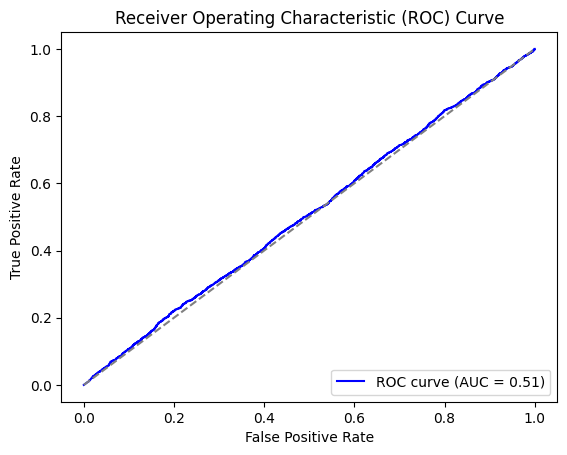

In [27]:
from sklearn.metrics import roc_curve, auc, classification_report

def calculate_youden_index(fpr, tpr, thresholds):
    youden_index = tpr - fpr
    optimal_threshold_index = np.argmax(youden_index)
    optimal_threshold = thresholds[optimal_threshold_index]
    return optimal_threshold

def evaluate_mlp_model(model, X_tensor, y_true_tensor):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations for evaluation
        # Forward pass to get predictions
        y_pred_probs = model(X_tensor)
        
        # Convert tensors to NumPy arrays for metric calculations
        y_true = y_true_tensor.numpy()
        y_pred_probs = y_pred_probs.numpy()
        
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
        
        # Calculate optimal threshold using Youden's Index
        optimal_threshold = calculate_youden_index(fpr, tpr, thresholds)
        print(f'Optimal Threshold: {optimal_threshold}')

        # Convert probabilities to binary predictions (0 or 1) using the optimal threshold
        y_pred = (y_pred_probs >= optimal_threshold).astype(float)
        
        # Detailed classification report
        report = classification_report(y_true, y_pred, target_names=['Dislike', 'Like'])
        print(report)
        
        # Plot ROC curve
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()

# Example usage of the evaluation function
evaluate_mlp_model(mlp_model, X_test_tensor, y_test_tensor)

## 1.3 Define a embedding lay included MLP
To explore how enbedding on category data will improve the performance of MLP or not

In [42]:
# Define the model
class MixedInputModelWithGender(nn.Module):
    def __init__(self, genre_vocab_size, occupation_vocab_size, zip_vocab_size, embedding_dim, num_numerical_features, num_gender_features):
        super(MixedInputModelWithGender, self).__init__()
        
        # Embedding layers for categorical features
        self.occupation_embedding = nn.Embedding(occupation_vocab_size, embedding_dim)
        self.zip_embedding = nn.Embedding(zip_vocab_size, embedding_dim)
        
        # Fully connected layers (adjusting input size to include gender one-hot features)
        self.fc1 = nn.Linear(embedding_dim * 2 + num_numerical_features + num_gender_features, 128)  # Including gender
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # For binary classification (1 output with sigmoid)
    
    def forward(self, X_categorical, X_numerical, X_gender):
        # Embeddings for categorical features
        occupation_embedded = self.occupation_embedding(X_categorical[:, 0])  # Second column: occupation
        zip_embedded = self.zip_embedding(X_categorical[:, 1])  # Third column: zip
        
        # Concatenate embeddings, numerical features, and one-hot encoded gender
        x = torch.cat([occupation_embedded, zip_embedded, X_numerical, X_gender], dim=1)
        
        # Pass through fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        output = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        
        return output

### 1.32 Initial training data and model then train

In [43]:
# Prepare the data 
data_train = train_dataset(df_train)
genre_len, occupation_len, zip_len = data_train.process_with_embeddings()
X_categorical_tensor, X_numerical_tensor, X_gender_tensor, y_tensor = data_train.mix_input_to_tensor()

In [44]:
# Initialize the model
model = MixedInputModelWithGender(
    genre_vocab_size=genre_len,  # Number of unique genres
    occupation_vocab_size=occupation_len,  # Number of unique occupations
    zip_vocab_size=zip_len,  # Number of unique states
    embedding_dim=8,  # Embedding size
    num_numerical_features=2,  # Number of numerical features (age, income)
    num_gender_features=1  # Number of one-hot encoded gender features (only 1 after drop_first=True)
)

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert y_tensor to float for BCELoss (binary cross-entropy loss expects float labels)
y_tensor = y_tensor.float()



In [45]:
# Training loop
epochs = 100
train_threshold = 0.1
for epoch in range(epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_categorical_tensor, X_numerical_tensor, X_gender_tensor)
    loss = criterion(outputs, y_tensor)  
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')

    if loss < train_threshold:
        break

Epoch [1], Loss: 0.7018
Epoch [2], Loss: 0.6971
Epoch [3], Loss: 0.6935
Epoch [4], Loss: 0.6907
Epoch [5], Loss: 0.6886
Epoch [6], Loss: 0.6872
Epoch [7], Loss: 0.6864
Epoch [8], Loss: 0.6859
Epoch [9], Loss: 0.6855
Epoch [10], Loss: 0.6852
Epoch [11], Loss: 0.6848
Epoch [12], Loss: 0.6843
Epoch [13], Loss: 0.6836
Epoch [14], Loss: 0.6828
Epoch [15], Loss: 0.6820
Epoch [16], Loss: 0.6812
Epoch [17], Loss: 0.6805
Epoch [18], Loss: 0.6798
Epoch [19], Loss: 0.6791
Epoch [20], Loss: 0.6786
Epoch [21], Loss: 0.6780
Epoch [22], Loss: 0.6775
Epoch [23], Loss: 0.6769
Epoch [24], Loss: 0.6764
Epoch [25], Loss: 0.6758
Epoch [26], Loss: 0.6752
Epoch [27], Loss: 0.6747
Epoch [28], Loss: 0.6741
Epoch [29], Loss: 0.6736
Epoch [30], Loss: 0.6731
Epoch [31], Loss: 0.6726
Epoch [32], Loss: 0.6722
Epoch [33], Loss: 0.6718
Epoch [34], Loss: 0.6714
Epoch [35], Loss: 0.6709
Epoch [36], Loss: 0.6706
Epoch [37], Loss: 0.6702
Epoch [38], Loss: 0.6698
Epoch [39], Loss: 0.6695
Epoch [40], Loss: 0.6692
Epoch [41

### 1.32 Evaluate on model

In [46]:
data_test = test_dataset(df_test)
genre_len, occupation_len, zip_len = data_test.process_with_embeddings()
test_X_categorical_tensor, test_X_numerical_tensor, test_X_gender_tensor, test_y_tensor = data_test.mix_input_to_tensor()

Optimal Threshold: 0.5634616017341614
              precision    recall  f1-score   support

     Dislike       0.49      0.61      0.54      3961
        Like       0.65      0.53      0.59      5468

    accuracy                           0.56      9429
   macro avg       0.57      0.57      0.56      9429
weighted avg       0.58      0.56      0.57      9429



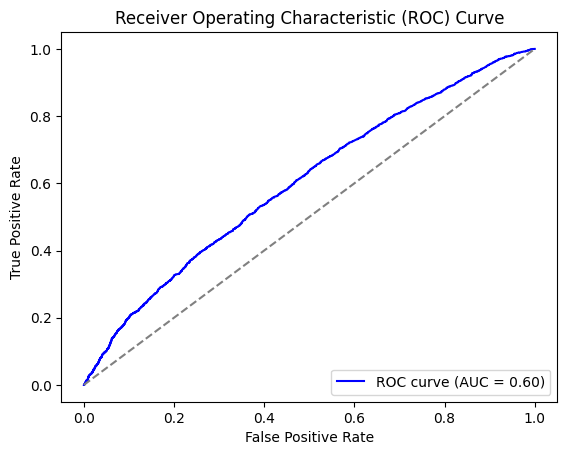

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,roc_curve,auc

def calculate_youden_index(fpr, tpr, thresholds):
    youden_index = tpr - fpr
    optimal_threshold_index = np.argmax(youden_index)
    optimal_threshold = thresholds[optimal_threshold_index]
    return optimal_threshold

def evaluate_model(model, X_categorical_tensor, X_numerical_tensor, X_gender_tensor, y_true_tensor):
    model.eval()  # Set model to evaluation mode
    # threshold = 0.5  # Threshold for binary classification
    with torch.no_grad():  # Disable gradient calculations for evaluation
        # Forward pass to get predictions
        y_pred_probs = model(X_categorical_tensor, X_numerical_tensor, X_gender_tensor)
        
        # Convert tensors to NumPy arrays for metric calculations
        y_true = y_true_tensor.numpy()
        y_pred_probs = y_pred_probs.numpy()
        
         # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
        
        # Calculate optimal threshold using Youden's Index
        optimal_threshold = calculate_youden_index(fpr, tpr, thresholds)
        print(f'Optimal Threshold: {optimal_threshold}')

        # Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
        y_pred = (y_pred_probs >= optimal_threshold).astype(float)
        # Calculate evaluation metrics
        # accuracy = accuracy_score(y_true, y_pred)
        # precision = precision_score(y_true, y_pred)
        # recall = recall_score(y_true, y_pred)
        # f1 = f1_score(y_true, y_pred)
        
        # Detailed classification report
        report = classification_report(y_true, y_pred, target_names=['Dislike', 'Like'])
        print(report)
        
         # Plot ROC curve
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
    # return accuracy, precision, recall, f1


# Example usage of the evaluation function
evaluate_model(model, test_X_categorical_tensor, test_X_numerical_tensor, test_X_gender_tensor, test_y_tensor)

## Conclusion on 1.3 approach:
It can be found that using embedding on the catageory input does out perform then using one hot encoding.\
The layer and neuron should be explored to optimal

# Caution!! This section of code will take 30 mins to run

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

df_k_fold = df_train.copy()

# One-hot encoding for gender
gender_ohe = pd.get_dummies(df_k_fold['user_gender'], drop_first=True)  # Drop first to avoid collinearity
df_k_fold = pd.concat([df_k_fold, gender_ohe], axis=1) 

# Encoding categorical features
categorical_cols = ['genre', 'user_occupation', 'user_zip']
oe = OrdinalEncoder()
df_k_fold[categorical_cols] = oe.fit_transform(df_k_fold[categorical_cols])

# Handling numerical features
scaler = StandardScaler()
df_k_fold[['user_age', 'release_date']] = scaler.fit_transform(df_k_fold[['user_age', 'release_date']])

# Separate categorical, numerical, and one-hot encoded gender
X_categorical_k_fold = df_k_fold[categorical_cols].values  # Ordinal encoded categorical data
X_numerical_k_fold = df_k_fold[['user_age', 'release_date']].values   # Scaled numerical data
X_gender_k_fold = df_k_fold[['M']].values  # One-hot encoded gender (only one column 'Male' due to drop_first=True)

# Convert labels
y_k_fold = df_k_fold['like_dislike'].values

# Define the model
class MixedInputModelWithGender(nn.Module):
    def __init__(self, genre_vocab_size, occupation_vocab_size, zip_vocab_size, embedding_dim, num_numerical_features, num_gender_features, num_layers, num_neurons, activation_fn):
        super(MixedInputModelWithGender, self).__init__()
        
        # Embedding layers for categorical features
        self.genre_embedding = nn.Embedding(genre_vocab_size, embedding_dim)
        self.occupation_embedding = nn.Embedding(occupation_vocab_size, embedding_dim)
        self.zip_embedding = nn.Embedding(zip_vocab_size, embedding_dim)
        
        # Fully connected layers (adjusting input size to include gender one-hot features)
        input_size = embedding_dim * 3 + num_numerical_features + num_gender_features
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, num_neurons))
            layers.append(activation_fn())
            input_size = num_neurons
        layers.append(nn.Linear(num_neurons, 1))  # For binary classification (1 output with sigmoid)
        self.fc = nn.Sequential(*layers)
    
    def forward(self, X_categorical, X_numerical, X_gender):
        # Embeddings for categorical features
        genre_embedded = self.genre_embedding(X_categorical[:, 0])  # First column: genre
        occupation_embedded = self.occupation_embedding(X_categorical[:, 1])  # Second column: occupation
        zip_embedded = self.zip_embedding(X_categorical[:, 2])  # Third column: zip
        
        # Concatenate embeddings, numerical features, and one-hot encoded gender
        x = torch.cat([genre_embedded, occupation_embedded, zip_embedded, X_numerical, X_gender], dim=1)
        
        # Pass through fully connected layers
        output = torch.sigmoid(self.fc(x))  # Sigmoid for binary classification
        
        return output

# Hyperparameter grid
embedding_dims = [8, 16]
learning_rates = [0.005, 0.01]
num_layers_list = [2, 3]
num_neurons_list = [64, 128, 256]
activation_functions = [nn.ReLU, nn.Tanh, nn.LeakyReLU]
batch_size = 32  # Fixed batch size
num_epochs = 50  # Fixed number of epochs

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for best hyperparameters and best score
best_hyperparams = None
best_score = 0

X_cat = X_categorical_k_fold
X_num = X_numerical_k_fold
X_gen = X_gender_k_fold
y = y_k_fold

# Iterate over hyperparameter combinations
for embedding_dim in embedding_dims:
    for learning_rate in learning_rates:
        for num_layers in num_layers_list:
            for num_neurons in num_neurons_list:
                for activation_fn in activation_functions:
                    fold_scores = []
                    tprs = []
                    mean_fpr = np.linspace(0, 1, 100)
                    
                    for train_index, val_index in kf.split(df_k_fold):
                        # Split data
                        X_cat_train, X_cat_val = X_cat[train_index], X_cat[val_index]
                        X_num_train, X_num_val = X_num[train_index], X_num[val_index]
                        X_gen_train, X_gen_val = X_gen[train_index], X_gen[val_index]
                        y_train, y_val = y[train_index], y[val_index]
                       
                        # Convert to PyTorch tensors
                        X_cat_train_tensor = torch.tensor(X_cat_train, dtype=torch.long)
                        X_cat_val_tensor = torch.tensor(X_cat_val, dtype=torch.long)
                        X_num_train_tensor = torch.tensor(X_num_train, dtype=torch.float32)
                        X_num_val_tensor = torch.tensor(X_num_val, dtype=torch.float32)
                        X_gen_train_tensor = torch.tensor(X_gen_train, dtype=torch.float32)
                        X_gen_val_tensor = torch.tensor(X_gen_val, dtype=torch.float32)
                        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
                        y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
                                    
                        # Initialize the model
                        model = MixedInputModelWithGender(
                            genre_vocab_size=len(oe.categories_[0]),  # Number of unique genres
                            occupation_vocab_size=len(oe.categories_[1]),  # Number of unique occupations
                            zip_vocab_size=len(oe.categories_[2]),  # Number of unique states
                            embedding_dim=embedding_dim,  # Embedding size
                            num_numerical_features=2,  # Number of numerical features (age, income)
                            num_gender_features=1,  # Number of one-hot encoded gender features (only 1 after drop_first=True)
                            num_layers=num_layers,  # Number of layers
                            num_neurons=num_neurons,  # Number of neurons in each layer
                            activation_fn=activation_fn  # Activation function
                        )
                        
                        # Define loss and optimizer
                        criterion = nn.BCELoss()  # Binary Cross-Entropy for binary classification
                        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                        
                        # Training loop
                        for epoch in range(num_epochs):
                            model.train()
                            
                            # Forward pass
                            outputs = model(X_cat_train_tensor, X_num_train_tensor, X_gen_train_tensor)
                            loss = criterion(outputs, y_train_tensor.unsqueeze(1))
                            
                            # Backward pass and optimization
                            optimizer.zero_grad()
                            loss.backward()
                            optimizer.step()
                        
                        # Validation
                        model.eval()
                        with torch.no_grad():
                            val_outputs = model(X_cat_val_tensor, X_num_val_tensor, X_gen_val_tensor)
                            val_loss = criterion(val_outputs, y_val_tensor.unsqueeze(1))
                            
                            # Calculate evaluation metrics
                            val_outputs = val_outputs.numpy()
                            y_val = y_val_tensor.numpy()
                            fpr, tpr, thresholds = roc_curve(y_val, val_outputs)
                            optimal_threshold = calculate_youden_index(fpr, tpr, thresholds)
                            y_pred = (val_outputs >= optimal_threshold).astype(float)
                            
                            accuracy = accuracy_score(y_val, y_pred)
                            precision = precision_score(y_val, y_pred)
                            recall = recall_score(y_val, y_pred)
                            f1 = f1_score(y_val, y_pred)
                            
                            fold_scores.append(f1)  # Using F1 score as the evaluation metric
                            
                            # Interpolate TPR for ROC curve
                            tpr_interp = np.interp(mean_fpr, fpr, tpr)
                            tpr_interp[0] = 0.0
                            tprs.append(tpr_interp)
                    
                    # Average score across folds
                    avg_score = np.mean(fold_scores)
                    
                    # Update best hyperparameters if current combination is better
                    if avg_score > best_score:
                        best_score = avg_score
                        best_hyperparams = {
                            'embedding_dim': embedding_dim,
                            'learning_rate': learning_rate,
                            'num_layers': num_layers,
                            'num_neurons': num_neurons,
                            'activation_fn': activation_fn
                        }

print(f'Best Hyperparameters: {best_hyperparams}')
print(f'Best F1 Score: {best_score:.4f}')



Best Hyperparameters: {'embedding_dim': 16, 'learning_rate': 0.01, 'num_layers': 2, 'num_neurons': 64, 'activation_fn': <class 'torch.nn.modules.activation.LeakyReLU'>}
Best F1 Score: 0.6701


In [48]:
# Train the best model on the entire training set
best_model = MixedInputModelWithGender(
    genre_vocab_size=len(oe.categories_[0]),
    occupation_vocab_size=len(oe.categories_[1]),
    zip_vocab_size=len(oe.categories_[2]),
    embedding_dim=best_hyperparams['embedding_dim'],
    num_numerical_features=2,
    num_gender_features=1,
    num_layers=best_hyperparams['num_layers'],
    num_neurons=best_hyperparams['num_neurons'],
    activation_fn=best_hyperparams['activation_fn']
)

# Define loss and optimizer for the best model
criterion = nn.BCELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_hyperparams['learning_rate'])

# Convert entire dataset to PyTorch tensors
X_cat_tensor = torch.tensor(X_cat, dtype=torch.long)
X_num_tensor = torch.tensor(X_num, dtype=torch.float32)
X_gen_tensor = torch.tensor(X_gen, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Training loop for the best model
for epoch in range(num_epochs):
    best_model.train()
    
    # Forward pass
    outputs = best_model(X_cat_tensor, X_num_tensor, X_gen_tensor)
    loss = criterion(outputs, y_tensor.unsqueeze(1))
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')
# Evaluate the best model on the validation set
best_model.eval()
with torch.no_grad():
    val_outputs = best_model(X_cat_tensor, X_num_tensor, X_gen_tensor)
    val_outputs = val_outputs.numpy()
    y_true = y_tensor.numpy()
    fpr, tpr, thresholds = roc_curve(y_true, val_outputs)
    optimal_threshold = calculate_youden_index(fpr, tpr, thresholds)
    y_pred = (val_outputs >= optimal_threshold).astype(float)
    
    # Print classification report
    print(classification_report(y_true, y_pred, target_names=['Dislike', 'Like']))
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

NameError: name 'oe' is not defined

              precision    recall  f1-score   support

     Dislike       0.60      0.65      0.62     40660
        Like       0.69      0.64      0.67     49902

    accuracy                           0.65     90562
   macro avg       0.64      0.65      0.64     90562
weighted avg       0.65      0.65      0.65     90562



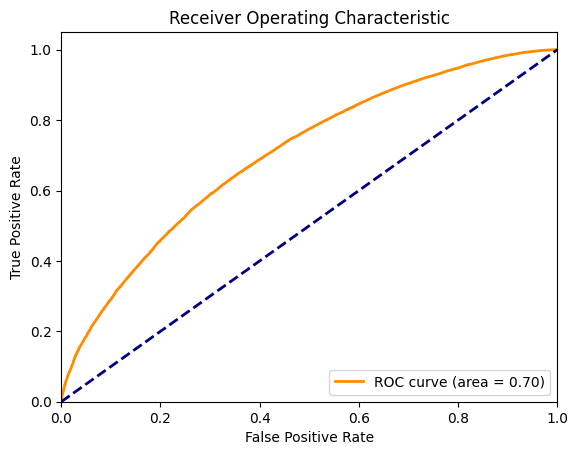

In [28]:
# Define the model with decreasing neurons in hidden layers
class MixedInputModelWithDecreasingNeurons(nn.Module):
    def __init__(self, genre_vocab_size, occupation_vocab_size, zip_vocab_size, embedding_dim, num_numerical_features, num_gender_features, num_layers, initial_neurons, activation_fn):
        super(MixedInputModelWithDecreasingNeurons, self).__init__()
        
        # Embedding layers for categorical features
        self.genre_embedding = nn.Embedding(genre_vocab_size, embedding_dim)
        self.occupation_embedding = nn.Embedding(occupation_vocab_size, embedding_dim)
        self.zip_embedding = nn.Embedding(zip_vocab_size, embedding_dim)
        
        # Fully connected layers with decreasing neurons
        input_size = embedding_dim * 3 + num_numerical_features + num_gender_features
        layers = []
        neurons = initial_neurons
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, neurons))
            layers.append(activation_fn())
            input_size = neurons
            neurons = max(neurons // 2, 1)  # Ensure at least 1 neuron in the layer
        layers.append(nn.Linear(input_size, 1))  # For binary classification (1 output with sigmoid)
        self.fc = nn.Sequential(*layers)
    
    def forward(self, X_categorical, X_numerical, X_gender):
        # Embeddings for categorical features
        genre_embedded = self.genre_embedding(X_categorical[:, 0])  # First column: genre
        occupation_embedded = self.occupation_embedding(X_categorical[:, 1])  # Second column: occupation
        zip_embedded = self.zip_embedding(X_categorical[:, 2])  # Third column: zip
        
        # Concatenate embeddings, numerical features, and one-hot encoded gender
        x = torch.cat([genre_embedded, occupation_embedded, zip_embedded, X_numerical, X_gender], dim=1)
        
        # Pass through fully connected layers
        output = torch.sigmoid(self.fc(x))  # Sigmoid for binary classification
        
        return output

# Train the best model on the entire training set
best_model = MixedInputModelWithDecreasingNeurons(
    genre_vocab_size=len(oe.categories_[0]),
    occupation_vocab_size=len(oe.categories_[1]),
    zip_vocab_size=len(oe.categories_[2]),
    embedding_dim=best_hyperparams['embedding_dim'],
    num_numerical_features=2,
    num_gender_features=1,
    num_layers=best_hyperparams['num_layers'],
    initial_neurons=best_hyperparams['num_neurons'],
    activation_fn=best_hyperparams['activation_fn']
)

# Define loss and optimizer for the best model
criterion = nn.BCELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_hyperparams['learning_rate'])

# Convert entire dataset to PyTorch tensors
X_cat_tensor = torch.tensor(X_cat, dtype=torch.long)
X_num_tensor = torch.tensor(X_num, dtype=torch.float32)
X_gen_tensor = torch.tensor(X_gen, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Training loop for the best model
for epoch in range(num_epochs):
    best_model.train()
    
    # Forward pass
    outputs = best_model(X_cat_tensor, X_num_tensor, X_gen_tensor)
    loss = criterion(outputs, y_tensor.unsqueeze(1))
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')
# Evaluate the best model on the validation set
best_model.eval()
with torch.no_grad():
    val_outputs = best_model(X_cat_tensor, X_num_tensor, X_gen_tensor)
    val_outputs = val_outputs.numpy()
    y_true = y_tensor.numpy()
    fpr, tpr, thresholds = roc_curve(y_true, val_outputs)
    optimal_threshold = calculate_youden_index(fpr, tpr, thresholds)
    y_pred = (val_outputs >= optimal_threshold).astype(float)
    
    # Print classification report
    print(classification_report(y_true, y_pred, target_names=['Dislike', 'Like']))
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()